# TODO!!!!
- Try: Use the custom non-neg min_max_norm thing
- Try: Use the custom NonNegMinMaxNorm thing with the L1 norm

In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.lib.stride_tricks import sliding_window_view

In [25]:

# load data
# df_map = pd.read_pickle('./60times10_CAPPI_raw').resample('1h').sum()
# df_map = pd.read_pickle('./8times12_CAPPI_raw').resample('1h').sum()
# H,W = 8,12
df_map = pd.read_pickle('./14times18_CAPPI_raw').resample('1h').sum()
H,W = 14,18
# df_map = pd.read_pickle('./18times22_CAPPI_raw').resample('1h').sum()
# H,W = 18,22
# df_map = pd.read_pickle('./40times60_CAPPI_raw').resample('1h').sum()
# H,W = 40,60
df_inputs = pd.read_pickle('./2020_input_data_four_areas')
# df_target = pd.read_pickle('../Drainage data/drainage_ANA_target')
# df_target_2 = pd.read_pickle('../Drainage data/drainage_ING_target')
df_target = pd.read_pickle('../Drainage data/all_drainage_data.pkl')
# Reshape/select data of interest
df_temp = df_inputs.iloc[:,[0]]


# Remove/reduce effect of cycle
cycle_length = 24
remove_cycle = lambda x,c : (np.nanmax([x[c],0]) + (x.diff(c).cumsum()/c).shift(-c))
remove_season = lambda x : x - x.rolling(24*7*2,min_periods = 0).min()

# for col in df_target:
#     df_target.loc[:,col] = remove_cycle(df_target.loc[:,col],cycle_length)
#     df_target.loc[:,col] = remove_season(df_target.loc[:,col])

# inputs = df_temp.dropna().iloc[1800:]
inputs = df_inputs.loc[:,['temperature','radiation','moist_pressure']]#.iloc[1800:]
target = df_target#.iloc[1800:]
# target_2 = df_target_2.dropna().iloc[1800:]

# H,W = 40,60
C = inputs.shape[-1]

dt_start = datetime.datetime(2020,1,1,0,0,0)
dt_end = datetime.datetime(2020,12,31,23,59,59)
new_index = pd.date_range(dt_start,dt_end, freq='1h')

inputs = inputs.resample('1h').sum().reindex(new_index)
df_map = df_map.resample('1h').sum().reindex(new_index)

df_target = df_target.resample('1h').mean().reindex(new_index)
df_target = df_target.drop('MOS-HOL',axis='columns').interpolate(method='linear')
# # target_2 = target_2.loc[common_index].resample('1h').interpolate(method='linear')

inputs = inputs.values
input_2d = df_map.values.reshape(-1,H,W) 
target = df_target.values
# # target = np.c_[target.values,target_2.values]
# target

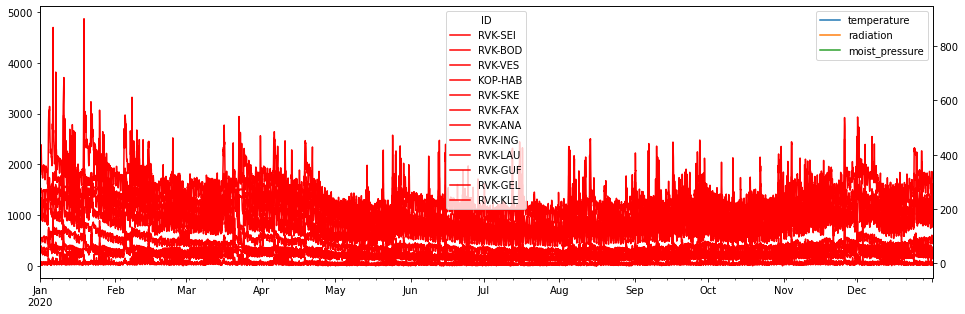

In [26]:

plt.figure(figsize=(16,5))
df_target.plot(color='red',ax=plt.gca())
plt.twinx().plot(inputs)
plt.legend(['temperature','radiation','moist_pressure'])
plt.show()


In [27]:
# input_2d.reshape(-1,H*W).shape

In [28]:
def correlate_pixel(series,lag = 0):
    radar_values = np.roll(series.values,lag).reshape(-1,1)
    drainage_values = target.reshape(-1,12)
    return np.corrcoef(radar_values,drainage_values,rowvar=False)[:,0]

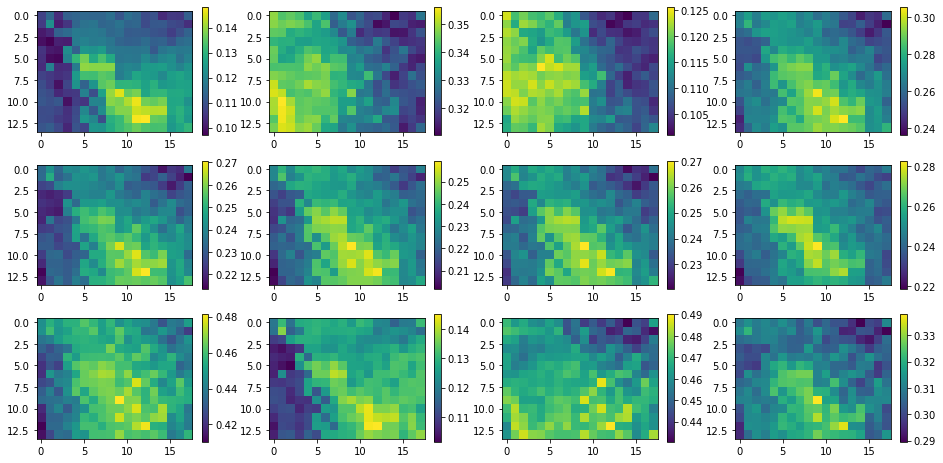

In [29]:
l = 1
correlate_pixel_lag = lambda x:correlate_pixel(x,lag = l)
correlation_grid = df_map.apply(correlate_pixel_lag).iloc[1:]

f,axes = plt.subplots(3,4,figsize=(16,8))

for i,ax in enumerate(axes.ravel()):
    im = ax.imshow(correlation_grid.iloc[i].values.reshape((H,W))[::-1])
    plt.colorbar(im, ax=ax)

In [35]:
# lag_values = np.arange(-70,70)
lag_values = np.arange(-10,10)
for l in lag_values:
    correlate_pixel_lag = lambda x:correlate_pixel(x,lag = l)
    correlation_grid = df_map.apply(correlate_pixel_lag).iloc[1:]

    f,axes = plt.subplots(3,4,figsize=(16,8))
    for i,ax in enumerate(axes.ravel()):
        im = ax.imshow(correlation_grid.iloc[i].values.reshape((H,W))[::-1])
        ax.set_title(df_target.columns[i])
        plt.colorbar(im, ax=ax)
    f.suptitle(f'Lag: {l}',fontsize=20)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'../Rainfall - runoff/Correlation structure analysis/small_cappi_correlation_lag_map_series/image_{l + 10}.png')
    
    plt.close()

In [36]:
plt.figure(figsize=(16,5))
df_target.plot(color='red',ax=plt.gca())
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
df_target.plot(color='red',ax=plt.gca())
df_inputs.iloc[:,[0,-1]].plot(ax = plt.twinx())
plt.legend()
plt.xlim(df_inputs.index[1600],df_inputs.index[2400])

In [ ]:
class MinMaxConstraint(tf.keras.constraints.Constraint):
    """constrain model weights between [x_min, x_max]."""
    def __init__(self, x_min=0.0, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        # TODO: add sanity check if x_max == x_min or w_max == w_min
    
    def __call__(self, w):
        is_geq = tf.cast(tf.greater_equal(w, self.x_min), tf.keras.backend.floatx())
        is_leq = tf.cast(tf.less_equal(w, self.x_max), tf.keras.backend.floatx())
        nis_geq = -1*(is_geq-1)
        nis_leq = -1*(is_leq-1)
        
        # only keep if it's bigger than min
        w = w * is_geq
        # set the ones not bigger than min to the min
        w = w + nis_geq * self.x_min
        # only keep if it's smaller than max
        w = w * is_leq
        # turn the ones not smaller to the min
        w = w + nis_leq * self.x_max
        return w
test_data = tf.reshape(tf.range(-5,5,dtype='float32')/2,(2,5), )
# print(test_data)
MinMaxConstraint(0.,1.)(test_data)
# print()

In [ ]:

# Settings
sequence_size = 2*7*24 # 4 weeks in hours
n_hidden = 20
n_outputs = target.shape[-1]
input_shape_1 = (sequence_size,H,W,1)
# S,H,W,C = input_shape_1

# Learning layers

conv_lstm = tf.keras.layers.ConvLSTM2D(filters = n_hidden,
                                       kernel_size = 1,
                                       strides = 1,
                                    #    activation='softplus', # only positive flow (Fron n_hidden sources)
                                       # activation=tf.keras.layers.LeakyReLU(alpha=0.05), # only positive flow (Fron n_hidden sources)
                                       activation='relu', # only positive flow (Fron n_hidden sources)
                                       # use_bias = False, # No default flow? (Already removed from time series)
                                       padding='same',
                                       data_format = 'channels_last',
                                       return_sequences = True,
                                       name = 'ConvLSTM2')

dense_point_flow = tf.keras.layers.Dense(1,
                                         activation='relu',
                                         name = 'flow_estimator',
                                         kernel_initializer = tf.keras.initializers.random_uniform(0.0001,0.1),
                                         bias_initializer = tf.keras.initializers.random_uniform(0.0001,0.1),)

dense_spatio_temporal_sum = tf.keras.layers.Dense(n_outputs,
                                                  activation = 'relu',
                                                  name = 'sum_up_over_space_and_time',
                                                  use_bias = True,
                                                  kernel_regularizer = tf.keras.regularizers.L2(100),
                                                  # Add upp the flow from different locations at different times (only positive flow)
                                                  # We technically know that the combined weight for both squares should never be more than 1
                                                  # I.e. min_max_norms along the (2) n_outputs dimension
                                                  # kernel_constraint = MinMaxConstraint(0.000001,1.),
                                                  kernel_initializer = tf.keras.initializers.random_uniform(0.0001,0.1),
                                                  bias_initializer = tf.keras.initializers.random_uniform(0.0001,0.1),
                                                #   kernel_constraint = tf.keras.constraints.MinMaxNorm(0.00001,1.0, rate = 0.99, axis = 1)
                                                  ) 



# Reshaping layers
input_concat = tf.keras.layers.Concatenate(-1, name = 'input_concat')
lstm_output_concat = tf.keras.layers.Concatenate(-1, name = 'lstm_output_concat')
map_flatten = tf.keras.layers.Flatten(name = 'map_flattener')


# Model construction
input_rain = tf.keras.layers.Input(input_shape_1, name = 'input_rain')
input_other = tf.keras.layers.Input(input_shape_1[:-1] + (inputs.shape[-1],), name = 'input_heat')
input_combined = input_concat([input_rain,input_other])

lstm_output = conv_lstm(input_combined)

flow_time_series = dense_point_flow(lstm_output[:,-16:]) # gather flow from all sources
flat_timeseries = map_flatten(flow_time_series)

drainage = dense_spatio_temporal_sum(flat_timeseries) # Heavily constrained adding up of all flows going into each catchment

model = tf.keras.Model([input_rain,input_other], drainage)
# Model visualization
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)
# model.summary()

In [74]:
start,end = 20,30
pred = model.predict([rainfall_input_sequences[start:end],temperature_input_sequences[start:end]])

print(np.mean((pred - output_sequences[start:end])**2))

f,axes = plt.subplots(4,3,figsize=(16,10))
for i,ax in enumerate(axes.ravel()):
    ax.plot(output_sequences[start:end,i])
    ax.plot(pred[:,i])
    ax.legend(['predicted','true'])

NameError: name 'model' is not defined

In [ ]:
output_sequences = sliding_window_view(target,(sequence_size,n_outputs)).squeeze()[:,-1]
rainfall_input_sequences = sliding_window_view(input_2d,(sequence_size,input_2d.shape[1],input_2d.shape[2])).reshape((-1,sequence_size,H,W,1))

temperature_map_placeholder = np.full((len(inputs),H,W,C),inputs[:,np.newaxis,np.newaxis])
temperature_input_sequences = sliding_window_view(temperature_map_placeholder,(sequence_size,H,W,C)).reshape((-1,sequence_size,H,W,C))

optimizer = tf.optimizers.Adam(learning_rate=1e-5, clipnorm = 0.01)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE])

val_ratio = 0.2
batch_size = 16
# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    model.fit([rainfall_input_sequences,temperature_input_sequences], output_sequences,
            validation_split = val_ratio,
            batch_size = batch_size,
            epochs = 50,
            verbose = 1,
            shuffle=True,
            )

In [ ]:
# snapshot_string = './TF-convLSTM models/75,8535_12677,5684_124,6675_29054,8711'
# model.save(snapshot_string)

In [ ]:
# model = model.load_weights(snapshot_string)

In [ ]:
y_pred = model.predict([rainfall_input_sequences,temperature_input_sequences])

In [ ]:
start,end = 20,30
pred = model.predict([rainfall_input_sequences[start:end],temperature_input_sequences[start:end]])

print(np.mean((y_pred - output_sequences)**2))

f,axes = plt.subplots(12,1,figsize=(16,5*12))
for i,ax in enumerate(axes.ravel()):
    ax.plot(y_pred[:,i])
    ax.plot(output_sequences[:,i])
    ax.legend(['predicted','true'])
    ax.set_title(df_target.columns[i])

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(output_sequences)
plt.plot(y_pred)

In [ ]:
[(i.name, i.shape) for i in model.weights]

In [ ]:
sum_up_over_time

In [ ]:
maps = model.weights[-1].numpy().reshape((336,H,W,2))

In [ ]:
maps[:,:,:,0].sum(axis=0)

In [ ]:
# plt.plot(maps.sum(axis=(1,2,3)))
# plt.plot(maps.sum(axis=(0,1,2)))
# plt.plot(maps.sum(axis=(0,1,3)))
plt.plot(maps.sum(axis=(0,2,3)))

In [ ]:
plt.imshow(maps[-1,:,:,0],vmin=0,vmax=1);plt.show()
plt.imshow(maps[-2,:,:,1]);plt.show()

In [ ]:
plt.imshow(maps[:,:,:,0].sum(axis=0),vmin=0,vmax=0.05);plt.show()
plt.imshow(maps[:,:,:,1].sum(axis=0),vmin=0,vmax=100);plt.show()

In [ ]:


# Start training cycle
global_step = 1

n_samples = len(training_data_loader.dataset)
n_steps = np.ceil(n_samples / training_data_loader.batch_size).astype(np.int32)

learning_rates = {#1:5e-2,
                  10: 2e-3,
                  20: 1e-3,
                  30: 5e-4,
                  35: 1e-4}

for epoch in range(1, 1000):
    if epoch in learning_rates.keys():
        for param_group in optimizer.param_groups:
            param_group["lr"] = learning_rates[epoch]
            
    # Train routine for a single epoch
    model.train()
    epoc_losses = []
    trues = []
    for i, (x, y) in enumerate(training_data_loader):
        x, y = x.permute((1,0,2)).to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        predictions, *_ = model(x)
        
        loss = loss_func(predictions.squeeze(), y.squeeze())
        # calculate gradients
        loss.backward()
        # perform parameter update
        optimizer.step()
        # lr_scheduler.step()

        # if (i + 1) % 1 == 0:
        # print(loss.item(),end='\r')
        epoc_losses.append(loss.item())
        
    model.eval()
    preds, obs = None, None
    with torch.no_grad():
        for i, (x, y) in enumerate(validation_data_loader):
            x, y = x.permute((1,0,2)).to(DEVICE), y.to(DEVICE)
            val_pred,*_ = model(x)
            val_loss = loss_func(val_pred.squeeze(),y)
            # train_error = loss = loss_func(predictions.squeeze(), y)
            print(f"Epoch {epoch} - Training loss {np.mean(epoc_losses)} - Test loss {np.mean(val_loss.item())}")

                # if cfg["tensorboard"]:
                #     writer.add_scalar('train/loss', loss.item(), global_step)

        if (global_step % 5) == 0:
            y_train_pred,*_= model(X_train.permute((1,0,2)))
            plt.figure(figsize=(12,5))
            plt.plot(y_train_pred.squeeze().cpu().detach().numpy())
            plt.plot(y_train.cpu().detach().numpy())
            plt.show()
            
            y_val_pred,*_= model(X_val.permute((1,0,2)))
            plt.figure(figsize=(12,5))
            plt.plot(y_val_pred.squeeze().cpu().detach().numpy())
            plt.plot(y_val.cpu().detach().numpy())
            plt.show()
            
            
        
    # Evaluation routine on validation set
    if (global_step % 100) == 0:
    
        weight_file =  f'model_state/model_epoch{epoch}.pt'
        torch.save(model.state_dict(), str(weight_file))
        
    global_step += 1

In [ ]:
# np.any(np.isnan(inputs))  

In [ ]:
output = model(X_train)

In [ ]:
X_train.permute()

In [ ]:
[i.shape for i in output]